In [34]:
from utils import load_data, calc_metrics, plot_metrics
from utils.constants import WINDOW_SIZE, Events

date = "2024-05-10"
station = "calg"
event: Events = "Forbush Decrease"

In [35]:
df = load_data(f"./data/{event.replace(' ', '')}/{date}/all.txt")
df.index = df["datetime"]
df.drop(columns="datetime", inplace=True)
df

,MXCO,NANM,CALM,ROME,AATB,BKSN,JUNG,JUNG1,LMKS,IRK2,...,NAIN,PWNK,THUL,MWSB,MWSN,SOPB,SOPO,DOMB,DOMC,TERA
datetime,,,,,,,,,,,,,,,,,,,,,
2024-05-10 00:00:00,220.867,254.313,74.050,117.433,1261.4,115.692,150.704,323.198,425.173,NaN,...,194.40,198.77,111.50,25.34,230.36,127.79,269.93,4.393,16.190,111.216
2024-05-10 00:01:00,225.217,253.632,69.950,NaN,1256.3,117.483,150.784,319.041,411.394,NaN,...,195.29,197.01,114.61,25.91,228.55,128.19,274.75,5.117,15.615,109.428
2024-05-10 00:02:00,216.833,249.994,70.450,119.500,1270.2,117.455,149.123,317.795,425.233,NaN,...,195.59,200.01,113.53,26.73,230.34,127.22,267.29,4.521,18.197,105.852
2024-05-10 00:03:00,223.100,254.035,68.833,119.067,1274.4,115.861,148.927,318.894,419.176,339.5,...,199.30,196.23,114.86,26.71,226.73,129.70,264.30,4.647,16.529,105.852
2024-05-10 00:04:00,222.600,256.309,71.933,118.950,1290.2,115.859,151.099,323.218,432.783,NaN,...,195.43,197.71,112.79,24.59,230.41,128.26,268.65,4.774,16.150,105.032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-11 23:55:00,209.883,240.845,67.400,113.783,1190.1,106.850,135.989,303.621,388.554,NaN,...,180.31,184.87,102.85,23.99,202.39,114.58,235.12,3.606,14.517,98.849
2024-05-11 23:56:00,206.000,238.533,62.683,113.950,1195.4,104.821,136.718,291.756,380.691,NaN,...,177.40,188.42,105.40,22.52,200.44,113.06,239.30,4.103,15.260,99.555
2024-05-11 23:57:00,207.000,241.676,65.433,112.150,1191.7,112.149,138.436,298.758,383.642,NaN,...,177.64,183.20,102.60,23.50,201.93,113.84,236.07,4.194,15.231,98.849


In [36]:
# Taking just one station for simplicity
station_df = df[[station.upper()]]
station_df

,CALG
datetime,
2024-05-10 00:00:00,280.876
2024-05-10 00:01:00,276.011
2024-05-10 00:02:00,275.583
2024-05-10 00:03:00,279.654
2024-05-10 00:04:00,272.327
...,...
2024-05-11 23:55:00,252.127
2024-05-11 23:56:00,247.303
2024-05-11 23:57:00,254.431


## Create Sliding Windows and calc metrics for each one

Sliding windows pandas documentation: [Here](https://pandas.pydata.org/docs/user_guide/window.html).  
Pandas `rolling` documentation: [Here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html#pandas.DataFrame.rolling).

Interesting metric to see: [Burstiness Parameter](https://arxiv.org/pdf/1604.01125)

In [37]:
result = calc_metrics(station_df, station=station, date=date)
result

,value_i,window_shape,entropy,permutation_entropy,higuchi,sampen,hurst,dfa,corr_dim,lyap_r,mfhurst_b
datetime_i,,,,,,,,,,,
2024-05-10 00:00:00,280.876,65,4.174322,2.521819,2.084363,inf,0.581216,0.858558,0.754947,0.033149,-0.021930
2024-05-10 00:01:00,276.011,66,4.189591,2.522992,2.084983,inf,0.576761,0.874138,0.866431,0.034782,-0.021074
2024-05-10 00:02:00,275.583,67,4.204628,2.515827,2.078809,inf,0.576761,1.036985,0.819850,-0.003725,-0.024003
2024-05-10 00:03:00,279.654,68,4.219444,2.510674,2.077642,inf,0.440825,0.887801,0.718308,0.045645,-0.019793
2024-05-10 00:04:00,272.327,69,4.234043,2.510995,2.071239,inf,0.451122,0.879406,0.841465,-0.005521,-0.016783
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-11 23:55:00,252.127,70,4.248425,2.574037,1.958329,3.401197,0.608670,1.015705,0.715042,-0.003028,0.075422
2024-05-11 23:56:00,247.303,69,4.234038,2.570223,1.963343,3.367296,0.630972,0.919109,0.639883,0.000356,0.068338
2024-05-11 23:57:00,254.431,68,4.219439,2.570800,1.964973,3.367296,0.660703,1.139888,0.626737,-0.001959,0.067222


## Plot everything

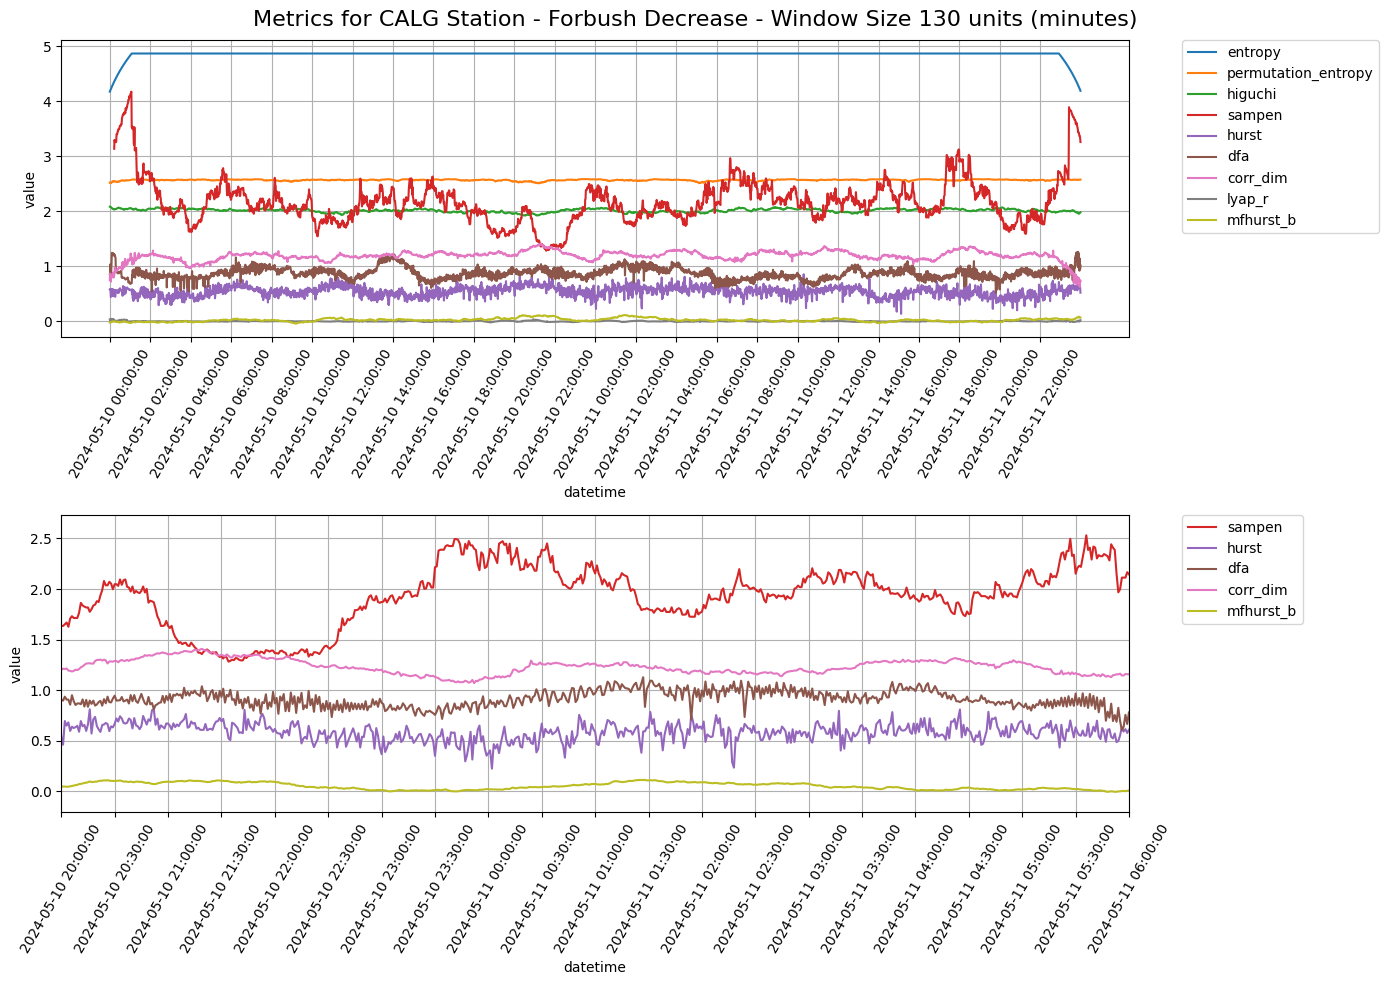

In [41]:
plot_metrics(
    event=event,
    date=date,
    station=station,
    window_size=WINDOW_SIZE,
    relevant_metrics=["sampen", "dfa", "hurst", "corr_dim", "mfhurst_b"],
    min_datetime="2024-05-10 20:00:00",
    max_datetime="2024-05-11 06:00:00",
)
